# YELP REVIEW Sentiment Analysis with BERT

We will fine tune the BERT model to be able to predict yelp reviews

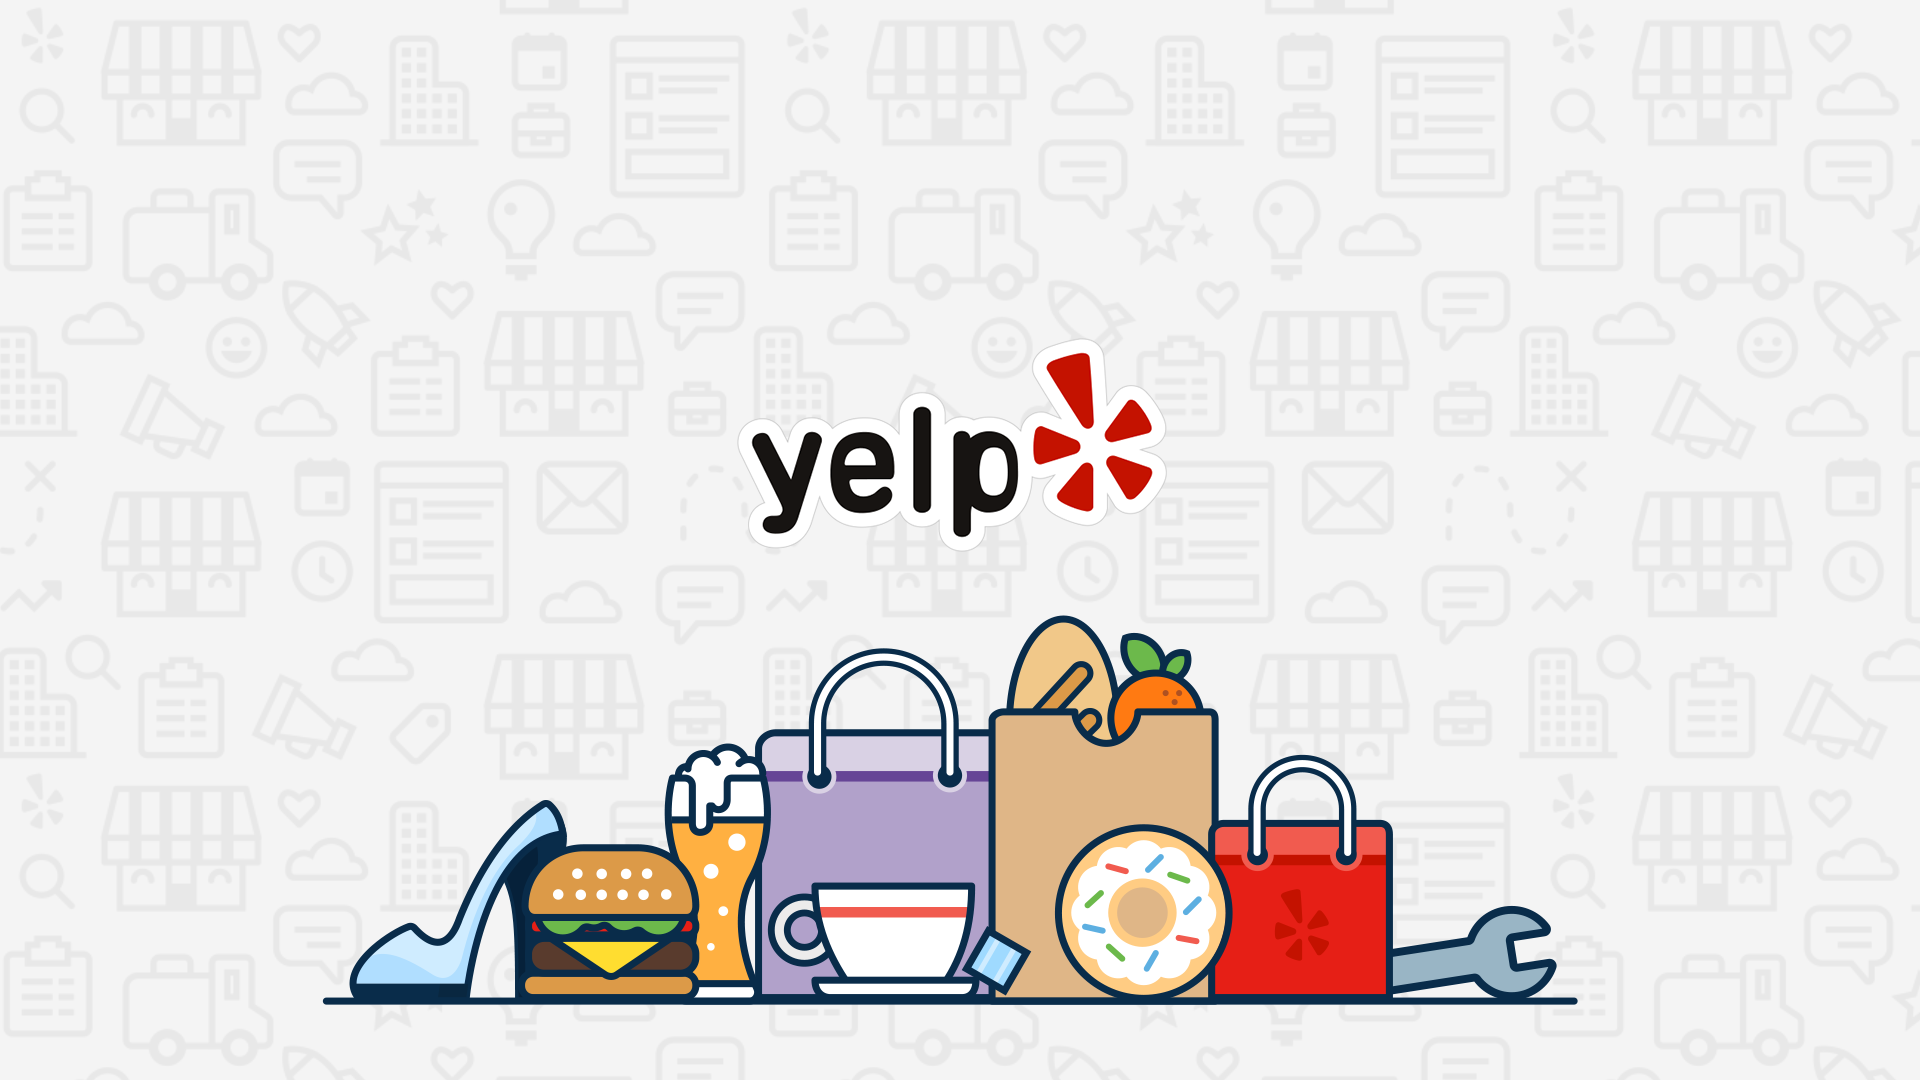

## Install and import dependencies

In [14]:
!pip install transformers requests beautifulsoup4 pandas numpy --quiet

In [2]:
# AutoTokenizer - Encode words to numbers
# AutoModelForSequenceClassification - Load the nlp model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

## Insantiate Model

In [21]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

## Encode and Calculate Sentiment

In [22]:
tokens = tokenizer.encode('The place was amazing but the menu was too dull', return_tensors='pt') # pt - Set it to pytorch

In [23]:
tokens

tensor([[  101, 10103, 11125, 10140, 39854, 10502, 10103, 43182, 10140, 14666,
         77617, 10159,   102]])

In [24]:
result = model(tokens)

In [25]:
result.logits

tensor([[-0.0857,  1.1400,  1.5220,  0.0301, -2.0595]],
       grad_fn=<AddmmBackward0>)

logits=tensor([[-2.7904, -1.3706,  1.1917,  2.0212,  0.7229] - These are the probabilities from the softmax function working with cross entropy at the final lasyer.

In [26]:
# Return the index of the max value from the logits
int(torch.argmax(result.logits))+1

3

## Collect YELP Reviews

In [11]:
r = requests.get('https://www.yelp.com/biz/yes-apothecary-new-york-4')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [9]:
results[1].text

'Great food, with choices suited to both dining or snacking with a drink. Creative cocktail menu with seasonal and staple drinks incorporating sichuan/chinese flavours and liquors hard to find anywhere else (ie. baijiu). Stop by for dinner or a drink and snack. Service was efficient with gracious FOH and servers.'

In [14]:
reviews[0]

'Great drinks and atmosphere! Rob was awesome and gave great insights into the drinks! Highly recommend'

## Load Reviews into dataframe and score

In [15]:
import numpy as np
import pandas as pd

In [18]:
# Get the reviews to a dataframe
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [19]:
df.head()

review
0  Great drinks and atmosphere! Rob was awesome a...
1  Great food, with choices suited to both dining...
2  Great vibes, knowledgeable staff with good rec...
3  Honestly my favorite Szechuan place in the cit...
4  Cozy bar with beautiful decor. Food seems pric...

In [20]:
df['review'].iloc[0]

'Great drinks and atmosphere! Rob was awesome and gave great insights into the drinks! Highly recommend'

In [28]:
# Pass the review to the tokenzier and the model and get the score
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [29]:
sentiment_score(df['review'].iloc[1])

5

In [30]:
sentiment_score(df['review'].iloc[3])

5

In [32]:
sentiment_score(df['review'].iloc[7])

4

In [33]:
# Use the apply method to automate sentiment analysis
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [34]:
df

review  sentiment
0  Great drinks and atmosphere! Rob was awesome a...          5
1  Great food, with choices suited to both dining...          5
2  Great vibes, knowledgeable staff with good rec...          5
3  Honestly my favorite Szechuan place in the cit...          5
4  Cozy bar with beautiful decor. Food seems pric...          4
5  First time here and the ambiance is as describ...          2
6  Nestled in the Lower East Side on the border o...          4
7  My boyfriend and I came here for dinner and we...          4
8  Ye's Apothecary is located below street and ma...          4
9  Dishes were flavorful and warming, especially ...          4

In [35]:
df['review'].iloc[3]

'Honestly my favorite Szechuan place in the city!The flavors were so bold and delicious . Each dish was so unique and left an amazing after taste of me wanting more. Perfect place to go if you want to order family style to try a little bit of everything . Service was great! Workers were fast and attentive . Cocktails were strong and delicious! I really enjoy the tofu dish! The restaurant is dark which sets a very mature and welcoming vibe to it! People outside said "this place looks good" and I said " it\'s so good you guys have to go in". Definitely worth checking out!'